In [25]:
using Plots
using Random
using Distributions
using LinearAlgebra
using StatsBase


# Item-item Recommendation System as a Random Walk on a Standard Simplex 
The notebook demonstrates a simulation procedure that can be used to evaluate a recommendation algorithm described in https://arxiv.org/abs/2302.01522.

Only brief explanations are provided here, more details can be found in the original paper.

## Item-item Recommender
One way or another, any item-to-item recommender system (see e.g. https://en.wikipedia.org/wiki/Item-item_collaborative_filtering), maintains a list of recommending products for every item of interest
\begin{equation}
	A \rightarrow  L =  \{ B_1,B_2, \cdots, B_n \}  \label{list}\tag{1}
\end{equation} 

In turn, a list on the right hand side of (\ref{list}) can be represented by a categorical distribution $X$ that is a point in a standard $n$-dimensional simplex $ X \in \Sigma^{n} \subset \mathbb{R}^n $. 
 
A random walk that we would like to simulate starts at a corner $ X_1 = (1, 0, \cdots, 0) $ of $\Sigma^{n}$. This choice corresponds to recommendation ranks 
 $R_1 = (1,0,\cdots, 0)$ with an assumption that a recommended  item initially has just one visited recommendation of probability (and rank)  $1$ and the ranks (click probabilities) of all other recommending items are essentially unknown.

An incoming click is thus represented by a selection of a vertex of $\Sigma^{n}$


## Incoming Click Distributions
The first moving part of our simulation model is a  sequence 
 $C_1, \cdots, C_{m-1}  $ of categorical 
  distributions represented by a sequence of points in $\Sigma^{n}$.  It is  assumed that the total number of simulated clicks $T$ is split into intervals (days) of random length $ t_1, t_2, \cdots , t_m, \;\; \sum_{i}^mt_i = T $. Assume that  click distribution changes occur at times
 $t_1, \; t_1 + t_2, \; \cdots, \; t_1 + t_2 \cdots + t_{m-1}$. In other words, 
 for any $ t $ in the semi-open interval $ T_k \equiv  ( t_1 + t_2 + \cdots + t_k, \; t_1 + t_2 + \cdots + t_{k+1}  ] $, the probability of an item $i$ to be clicked at "time" $t$ (that is for the i-th vertex of $\Sigma^{n}$ to be selected) is equal to the $i$-th coordinate of $C_k$.  Assume also, that interval length  distribution has a small variance, for example, let $ |T_k| \sim N(\mu, \sigma)$ with $ \sigma=\frac{1}{5}\mu $.  Further, it is reasonable to assume that the point $C_{i+1}$ is close to the point $C_i$, for example, let $C_{i+1}$  differ from $C_i$ by a Gaussian noise. 

Next two functions implement incoming click distribution switching procedure and time interval generation (cf. https://juliastats.org/Distributions.jl/stable/)    

In [26]:
function nextDistribution( C::Distributions.Categorical; eps=.01 )
    X = C.p
    n = size(X)[1]                  # dimension of the simplex
    S = rand(n,n); S = S'S          # generate a random symmetric positive definite matrix,
    I_n = Diagonal( ones(n))
    S = I_n + eps * S               # take a small positive definite perturbation of the unity matrix
    G = MvNormal( X, S )            # and define Gaussean distribution with the mean X and covariance S
    v = abs.( rand(G, 1 ) )[:,1]    # get random, positive ""almost G-distributed"" vector
    X = v/sum(v)                    # and turn it into categorical probability distribution
    return Categorical(X)
end


nextDistribution (generic function with 1 method)

In [27]:
function generate_time_intervals( clicks_per_day, n_days )
    N = Normal( clicks_per_day, .2 * clicks_per_day )
    x = rand( N, n_days )
    x = max.( x, 2 )   # keep it for at least 2days
    return convert.( Int32, ceil.( x ) )
end

generate_time_intervals (generic function with 1 method)

## Simulation Algorithm 
The second moving part of the simulation is  a straightforward implementation of the algorithm described in https://arxiv.org/abs/2302.01522 when applied to just one anchor, with the assumption that item clicks come from the sequence of categorical distributions $C_k, \; k = 1,2, \cdots $

Let  $ t+1 \in T_k $, let $ i $ be a random index sampled from the distribution $C_k$ at time $t +1 $ and let $\alpha$ be a fixed smoothing parameter. Then  for 
probabilities  $ X_{t,j} $ and  rank (frequency counters) $R_{t,j} $ 
we have :

- if $ X_{t,i} \neq 0 $ (already visited recommendation) then 

\begin{equation}
	X_{t+1,j} = \alpha X_{t,j} \;\; \text{for} \;\; j= 1,2, \cdots n, \; j \neq i  \nonumber 
\end{equation}

and

\begin{eqnarray}
	X_{t+1,i} = \alpha X_{t,i} + 1 - \alpha  \nonumber \\
	R_{t+1, i } =  R_{t, i } + 1  	\nonumber
\end{eqnarray}

- if $ X_{t,i} = 0 $ (a case when a clicked item is not in the list  (1)) then $ X_{t+1,i} $ is a maximum entropy mixture of the ditrsibutions  

\begin{eqnarray}
	X_t = ( p_1, \; \cdots ,\; 0, \;  \cdots \; , p_n)  \\
	\Delta_i = ( 0, \;  \cdots , \; 1, \;  \cdots \; ,  0)
\end{eqnarray}

- and in any case 

\begin{align}
	R_{t+1, i } =  R_{t, i } + 1  	\nonumber
\end{align}

where for all variables, the first index ($t$) is
a simulation iteration number (click "time") and the second index ($j$) is a vector coordinate.

The maximum entropy (cf. arXiv:1011.0723, arXiv:2302.01522) mixture distribution is computed by the following function

In [28]:
# maximum entropy mixture of categorical probability distribution p and c,
# note that entropy is a convex function of the mixture parameter  
function maxent( p::Vector{Float64}, c::Vector{Float64} ):Float64
    
    log0(x) = x == 0 ? 0 : log(x)

    n = 1000
    v = range(0, 1, n )

    ent(a) = - dot( a * p .+  ( 1 - a ) * c , log0.( a * p .+  ( 1 - a ) * c ) )

    f1 = ent( v[1]) ; f2 = ent(v[2])
    if f2 < f1
        return f1
    end
    i = 2
    while i < n && f1 < f2
        i += 1 ; f1 = f2; f2 = ent( v[i] )
    end

    return v[i]
end

maxent (generic function with 1 method)

## Evaluation 
The simulation generates two categorical distribution sequences

- $X_t$ for the algorithm described in https://arxiv.org/abs/2302.01522
- a click frequency distribution $\hat{R_t} $ defined by averaging click counters

	\begin{equation}
		\hat{R_t} = \left( \frac{ 1}{\sum_{i=1}^n  R_{t,i}} \right) R_t  \nonumber
	\end{equation} 

and the the results are evaluated by plotting (https://docs.juliaplots.org/stable/) cumulative (daily) $L_1$ norms of differences $|X_t - C_k| $  and  $ | \hat{R_t} - C_k| $.


Finally, the entropies of simulated distributions $X_t$ are plotted for all $t$ 



random click split between days
Int32[11, 8, 10, 8, 10, 10, 10, 13, 8, 9, 16, 15, 13, 9]
average diff_X=0.5996726866793873 average diff_Y=0.6813625394430435


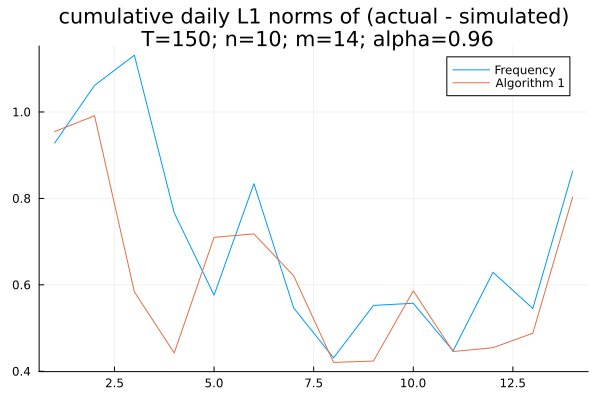

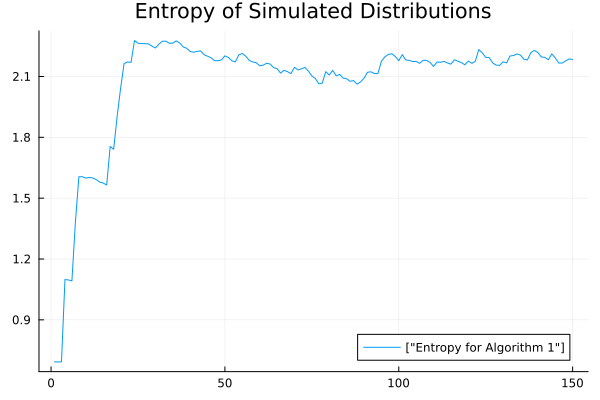

In [47]:
    n = 10          # simplex dimension
    alpha = .96
 
    R = zeros(n) ; R[1] = 1    # initial ranks
    RP = zeros(n); RP[1] = 1   # initial probability  (1,0,0,...)  (simplex corner)

    n_days = 14 
    t = 10                     # approximate number of clicks per day (se below)

    # split randomly between days
    random_click_split = generate_time_intervals( t, n_days ) 

    T = sum( random_click_split)     # total number of iterations
    println( "random click split between days")
    println( random_click_split )

    entropies = zeros(T)

    # generate initial icoming click distribution
    E = Exponential( 1000 )
    
    P0 = rand(E, 10 )
    P0 /= sum(P0)
   
    C = Categorical(P0)
    X = copy(RP)
    Y = copy( R )
  
    R_norm_diff = zeros(n_days)
    X_norm_diff = zeros(n_days)

    diff_X = 0; diff_Y = 0;
    lct = 1
  
    for i in 1:n_days
        # incoming clicks on day i
        p_index  = rand(C, random_click_split[i] )
      
        for j_ in 1:random_click_split[i]
            j = p_index[j_]
            if X[j] > 0
                X = alpha * X; X[j] += ( 1 - alpha )  
            else
                # maxent
                c = zeros(n)
                c[j] = 1
                a = maxent( X, c ) 
                X = a * X; X[j] += ( 1 - a )
            end

            Y[j] += 1                                    # event (frequency counting)

            diff_X += norm( X - C.p, 1 )                 # accumulate total diff
            diff_Y += norm( Y/sum(Y) - C.p, 1 )
            
            R_norm_diff[i] += norm( Y/sum(Y) - C.p, 1 )  # and daily diff
            X_norm_diff[i] += norm( X - C.p, 1 )
        
            entropies[lct] = entropy( X )
            lct += 1
              
        end


        R_norm_diff[i] /= random_click_split[i]
        X_norm_diff[i] /= random_click_split[i]
       
        C = nextDistribution(C)     # while incoming distribution keeps changing
    
    end
        
    Y_end = Y / sum(Y)              # turn counters into frequencies (probabilities)
   
    title = "cumulative daily L1 norms of (actual - simulated)\n T=$T; n=$n; m=$n_days; alpha=$alpha"

    T_ = size(R_norm_diff)[1]       # total number of iterations 
      
    println( "average diff_X=", (diff_X/T), " average diff_Y=", (diff_Y/T) )
    pl = plot( 1:T_, [R_norm_diff, X_norm_diff], label=["Frequency" "Algorithm 1"], title=title)
        
    display(pl)
    #println("\n press enter to continue ")
    #readline()

    pl = plot( 1:T, [entropies], label=["Entropy for Algorithm 1"], title="Entropy of Simulated Distributions")
    display(pl)
    #println("\n press enter to continue ")
    #readline()
    

### In Conclusion

The simulation demonstrates that the recommender algorithm suggested in https://arxiv.org/abs/2302.01522 is better than straightforward incoming click (frequency) counting  

#### Useful links:

- https://en.wikipedia.org/wiki/Item-item_collaborative_filtering)
- https://en.wikipedia.org/wiki/Recommender_system
- https://en.wikipedia.org/wiki/Exponential_smoothing
- https://en.wikipedia.org/wiki/Random_walk
- Ariel Caticha, "Entropic Inference", https://arxiv.org/abs/1011.0723
- https://juliastats.org/Distributions.jl/stable/
- https://docs.juliaplots.org/stable/
